In [1]:
# Load "autoreload" extension so that code can change; set it so modules are reloaded before execution
%load_ext autoreload
%autoreload 2

$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\braket}[3]{\left\langle{#1}\left|{#2}\right|{#3}\right\rangle}
\newcommand{\kd}[2]{\delta_{#1, #2}}
$
A nucleus of spin $ I > 1/2 $ exposed to external magnetic field $ \mathbf{B}_0 $ and an internal magnetic field $ \mathbf{B}_\mathrm{i} $ is governed by Zeeman and quadrupolar effects. The Hamiltonian, for an arbitrary set of axes, can be written as

$$
\begin{equation}
    H = \hbar \gamma \mathbf{I} \cdot \mathbf{B}_0
       + \hbar \gamma \mathbf{I} \cdot \mathbf{B}_\mathrm{i}
       + \frac{eQ}{4I(2I-1)}
       \left[
           V_{zz}(3I_z^2 - I^2)
           + V_{+1} \left\{ I_-, I_z \right\}
           + V_{-1} \left\{ I_+, I_z \right\}
           + V_{+2}I_-^2 + V_{-2}I_+^2
       \right],
\end{equation}
$$

where

\begin{gather}
    V_{\pm1} = V_{zx} \pm \mathrm{i}V_{zy},
    \\
    V_{\pm2} = \frac{1}{2} \left( V_{xx} - V_{yy} \right) \pm \mathrm{i}V_{xy}.
\end{gather}

Given a non-diagonalized and diagonalized EFG tensor, $ V $ and $ V' $, it is straightforward to rotate into the principle axes frame by the rotation matrix $ R = V'V^{-1} $. This simplifies the Hamiltonian to

$$
\begin{equation}
    H = \hbar \gamma \mathbf{I} \cdot R\mathbf{B}_0
       + \hbar \gamma \mathbf{I} \cdot R\mathbf{B}_\mathrm{i}
       + \frac{eQ}{4I(2I-1)}
       \left[
           V_{zz}(3I_z^2 - I^2)
           + \left( V_{xx} - V_{yy} \right) \left( I_x^2 - I_y^2 \right)
       \right].
\end{equation}
$$

To find the matrix representation, the spin angular momentum operators can be written in terms of the raising and lowering operators: $ I_x = (I_+ + I_-)/2 $, $ I_y = (I_+ - I_-)/2\mathrm{i} $. Of course, the raising and lower operators have the following effect on a state:

\begin{equation}
    I_\pm \ket{m} = \sqrt{(I \mp m)(I \pm m + 1)} \ket{m+1} \equiv C_\pm \ket{m\pm1}
\end{equation}

where $ C_\pm(m) $ is defined for convenience. So, we have the matrix elements for the raising and lowering operators in the Zeeman basis:

\begin{equation}
    \braket{m'}{I_\pm}{m} = C_\pm \kd{m'}{m\pm1}.
\end{equation}

Utilizing this representation, we have

\begin{align}
    \braket{m'}{I_x}{m} &= \frac{1}{2}\left( C_+\kd{m'}{m+1} + C_-\kd{m'}{m-1} \right),
    \\
    \braket{m'}{I_y}{m} &= \frac{1}{2\mathrm{i}}\left( C_+\kd{m'}{m+1} - C_-\kd{m'}{m-1} \right),
    \\
    \braket{m'}{I_z}{m} &= m\kd{m'}{m}.
\end{align}

These expressions can be used to build up an analytical matrix representation of the Hamiltonian.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nmrlib.core as nmr
import nmrlib.quantum as quant
from scipy.constants import h, e, hbar, mega, k
import scipy.special
import sympy as sp
import matplotlib as mpl
from matplotlib.colors import from_levels_and_colors
from matplotlib.collections import LineCollection
import pandas as pd
import dill
import os.path as op
mpl.rc('axes.formatter', useoffset=False)

DATAPATH = op.abspath('../data')

class Bunch(object):
    def __init__(self, adict):
        self.__dict__.update(adict)
        
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
    
def C(pm, m, I, t='sympy'):
    pm1 = {'+': -1, '-': +1}
    pm2 = {'+': +1, '-': -1}
    func = {'sympy': sp.sqrt, 'numpy': np.sqrt}
    
    return func[t]((I + pm1[pm]*m)*(I + pm2[pm]*m + 1))

def get_Hq(I, Q, V):
    _Vxx = np.array(V[0][0])
    _Vyy = np.array(V[1][1])
    _Vzz = np.array(V[2][2])
    _Vzx = np.array(V[2][0])
    _Vzy = np.array(V[2][1])
    _Vxy = np.array(V[1][0])
    Vxx = _Vxx.reshape(_Vxx.size, 1, 1) # Reshape to permit broadcasting
    Vyy = _Vyy.reshape(_Vyy.size, 1, 1)
    Vzz = _Vzz.reshape(_Vzz.size, 1, 1)
    Vzx = _Vzx.reshape(_Vzx.size, 1, 1)
    Vzy = _Vzy.reshape(_Vzy.size, 1, 1)
    Vxy = _Vxy.reshape(_Vxy.size, 1, 1)
    Ix, Iy, Iz, Ip, Im = quant.get_spin_matrices(I)
    I2 = I*(I + 1)*np.identity(int(2*I + 1))
    H = (e*Q/(4*I*(2*I - 1)))*(Vzz*(3*Iz@Iz - I2)
                               + (Vzx + 1.j*Vzy)*(Im@Iz + Iz@Im)
                               + (Vzx - 1.j*Vzy)*(Ip@Iz + Iz@Ip)
                               + ((Vxx - Vyy)/2 + 1.j*Vxy)*(Im@Im)
                               + ((Vxx - Vyy)/2 - 1.j*Vxy)*(Ip@Ip))

    return H
    
def get_Hz(I, gamma, B0, Bint):
    B0x, B0y, B0z = (np.array(B0[0]), np.array(B0[1]), np.array(B0[2]))
    Bintx, Binty, Bintz = (np.array(Bint[0]), np.array(Bint[1]), np.array(Bint[2]))
    Ix, Iy, Iz, Ip, Im = quant.get_spin_matrices(I)
    Bintx = Bintx.reshape(Bintx.size, 1, 1)
    Binty = Binty.reshape(Binty.size, 1, 1)
    Bintz = Bintz.reshape(Bintz.size, 1, 1)
    B0x = B0x.reshape(B0x.size, 1, 1)
    B0y = B0y.reshape(B0y.size, 1, 1)
    B0z = B0z.reshape(B0z.size, 1, 1)
    H = hbar*gamma*(Ix*(B0x + Bintx) + Iy*(B0y + Binty) + Iz*(B0z + Bintz))

    return H

def get_sym_H(I, Bi, BL):
    n = int(2*I + 1)
    syms.I, syms.e, syms.hbar = sp.symbols('I e hbar', real=True, positive=True)
    syms.Q, syms.Vxx, syms.Vyy, syms.Vzz, syms.Vzx, syms.Vzy, syms.Vxy, syms.eta, syms.gamma = sp.symbols("Q V_xx V_yy V_zz V_zx V_zy V_xy eta gamma", real=True)
    [Ix, Iy, Iz, Ip, Im] = [np.zeros((n, n), dtype=object) for _ in range(5)]
    for i in range(0, n):
        for j in range(0, n):
            m = sp.Rational(i - I)
            mp = sp.Rational(j - I)
            Ix[n-j-1, n-i-1] = (C('+', m, syms.I)*int(mp == m+1) + C('-', m, syms.I)*int(mp == m-1))/2
            Iy[n-j-1, n-i-1] = (C('+', m, syms.I)*int(mp == m+1) - C('-', m, syms.I)*int(mp == m-1))/2/sp.I
            Iz[n-j-1, n-i-1] = m*int(mp == m)
    Ip = Ix + sp.I*Iy
    Im = Ix - sp.I*Iy
    I2 = (Ix@Ix + Iy@Iy + Iz@Iz)*int(mp == m)
    Hz = syms.hbar*syms.gamma*((Bi[0] + BL[0])*Ix + (Bi[1] + BL[1])*Iy + (Bi[2] + BL[2])*Iz)
    Hq = (syms.e*syms.Q/(4*syms.I*(2*syms.I - 1)))*((syms.Vzz)*(3*Iz@Iz - I2)
                                                    + (syms.Vzx + sp.I*syms.Vzy)*(Im@Iz + Iz@Im)
                                                    + (syms.Vzx - sp.I*syms.Vzy)*(Ip@Iz + Iz@Ip)
                                                    + ((syms.Vxx - syms.Vyy)/2 + sp.I*syms.Vxy)*Im@Im
                                                    + ((syms.Vxx - syms.Vyy)/2 - sp.I*syms.Vxy)*Ip@Ip)
        
    return sp.simplify(sp.Matrix(Hz + Hq).subs(syms.I, sp.Rational(I)))

def eig_sort(E, V):
    n = V.shape[-1]
    E_sorted = np.sort(E)
    E_sorted_indices = np.argsort(E)
    E_indices = np.squeeze([np.tile(_, (n, 1)) for _ in E_sorted_indices])
    V_sorted = np.take_along_axis(V, E_indices, axis=-1)
    
    return E_sorted, V_sorted

def find_max_min(arrays):
    _max = np.amax(arrays[0])
    _min = np.amin(arrays[0])
    for a in arrays:
        if np.amax(a) > _max:
            _max = np.amax(a)
        if np.amin(a) < _min:
            _min = np.amin(a)
    
    return _max, _min

def find_nearest(array, value):
    array = np.asarray(array)
    index = (np.abs(array - value)).argmin()
    
    return index

Suppose the nucleus of interest is spin 3/2. Using the above formulas will yield a matrix representation of the Hamiltonian in the Zeeman basis and in an arbitrary Cartesian coordinate system. Suppose that the internal magnetic field in the crystal points along $ z $ and the applied fields along $ x $, then the Hamiltonian may be computed as

In [3]:
I = 3/2
dim = int(2*I + 1)
syms = Bunch({})
syms.Bi, syms.BL, syms.wL, syms.wi, syms.wzz = sp.symbols('B_i B_L omega_L omega_i omega_zz', real=True)
Bi = [0, 0, syms.Bi]
BL = [syms.BL, 0, 0]
syms.H = get_sym_H(I, Bi, BL)
syms.H

Matrix([
[                   3*B_i*gamma*hbar/2 + Q*V_zz*e/4, sqrt(3)*(3*B_L*gamma*hbar + Q*e*(V_zx - I*V_zy))/6,            sqrt(3)*Q*e*(V_xx - 2*I*V_xy - V_yy)/12,                                                  0],
[sqrt(3)*(3*B_L*gamma*hbar + Q*e*(V_zx + I*V_zy))/6,                      B_i*gamma*hbar/2 - Q*V_zz*e/4,                                     B_L*gamma*hbar,            sqrt(3)*Q*e*(V_xx - 2*I*V_xy - V_yy)/12],
[           sqrt(3)*Q*e*(V_xx + 2*I*V_xy - V_yy)/12,                                     B_L*gamma*hbar,                     -B_i*gamma*hbar/2 - Q*V_zz*e/4, sqrt(3)*(3*B_L*gamma*hbar - Q*e*(V_zx - I*V_zy))/6],
[                                                 0,            sqrt(3)*Q*e*(V_xx + 2*I*V_xy - V_yy)/12, sqrt(3)*(3*B_L*gamma*hbar - Q*e*(V_zx + I*V_zy))/6,                   -3*B_i*gamma*hbar/2 + Q*V_zz*e/4]])

Further, suppose the system has crystal symmetry and magnetic ordering such that the internal field is coparallel with the crystallographic $ z $ direction. These assumptions give the special case of the above Hamiltonian:

In [4]:
syms.H = syms.H.subs({syms.Vzx: 0, syms.Vzy: 0, syms.Vxy: 0})
syms.H

Matrix([
[3*B_i*gamma*hbar/2 + Q*V_zz*e/4,      sqrt(3)*B_L*gamma*hbar/2,   sqrt(3)*Q*e*(V_xx - V_yy)/12,                                0],
[       sqrt(3)*B_L*gamma*hbar/2, B_i*gamma*hbar/2 - Q*V_zz*e/4,                 B_L*gamma*hbar,     sqrt(3)*Q*e*(V_xx - V_yy)/12],
[   sqrt(3)*Q*e*(V_xx - V_yy)/12,                B_L*gamma*hbar, -B_i*gamma*hbar/2 - Q*V_zz*e/4,         sqrt(3)*B_L*gamma*hbar/2],
[                              0,  sqrt(3)*Q*e*(V_xx - V_yy)/12,       sqrt(3)*B_L*gamma*hbar/2, -3*B_i*gamma*hbar/2 + Q*V_zz*e/4]])

Using the substitutions $ \omega_{zz} = eQ\left|V_{zz}\right|/2\hbar $, $ \omega_\mathrm{i} = \gamma B_\mathrm{i} $, and $ \omega_L = \gamma B_L $, we have

In [5]:
syms.H = syms.H.subs({syms.e*syms.Q*syms.Vzz/(2): syms.hbar*syms.wzz,
                      syms.gamma*syms.Bi: syms.wi,
                      syms.gamma*syms.BL: syms.wL})
syms.H = sp.simplify(syms.H).subs(syms.Vxx - syms.Vyy, syms.eta*syms.Vzz).subs(syms.e*syms.Q*syms.Vzz/(2), syms.hbar*syms.wzz)
syms.H

Matrix([
[hbar*(3*omega_i + omega_zz)/2,      sqrt(3)*hbar*omega_L/2,  sqrt(3)*eta*hbar*omega_zz/6,                              0],
[       sqrt(3)*hbar*omega_L/2, hbar*(omega_i - omega_zz)/2,                 hbar*omega_L,    sqrt(3)*eta*hbar*omega_zz/6],
[  sqrt(3)*eta*hbar*omega_zz/6,                hbar*omega_L, -hbar*(omega_i + omega_zz)/2,         sqrt(3)*hbar*omega_L/2],
[                            0, sqrt(3)*eta*hbar*omega_zz/6,       sqrt(3)*hbar*omega_L/2, hbar*(-3*omega_i + omega_zz)/2]])

And, with no external field:

In [6]:
syms.H = syms.H.subs(syms.wL, 0)
syms.H

Matrix([
[hbar*(3*omega_i + omega_zz)/2,                           0,  sqrt(3)*eta*hbar*omega_zz/6,                              0],
[                            0, hbar*(omega_i - omega_zz)/2,                            0,    sqrt(3)*eta*hbar*omega_zz/6],
[  sqrt(3)*eta*hbar*omega_zz/6,                           0, -hbar*(omega_i + omega_zz)/2,                              0],
[                            0, sqrt(3)*eta*hbar*omega_zz/6,                            0, hbar*(-3*omega_i + omega_zz)/2]])

The eigenvalues and eigenvectors for this Hamiltonian are given below in the form of (eigenvalue, multiplicity, eigenvector).

In [7]:
a, b, nrmlz = ([None]*2, [None]*2, [None]*4)
a[0] = 6*syms.wi - 3*syms.wzz
b[0] = sp.sqrt(3*((syms.eta*syms.wzz)**2 + 12*syms.wi**2 - 12*syms.wi*syms.wzz + 3*syms.wzz**2))
a[1] = 6*syms.wi + 3*syms.wzz
b[1] = sp.sqrt(3*((syms.eta*syms.wzz)**2 + 12*syms.wi**2 + 12*syms.wi*syms.wzz + 3*syms.wzz**2))
nrmlz[0] = a[0] - b[0]
nrmlz[1] = a[0] + b[0]
nrmlz[2] = a[1] - b[1]
nrmlz[3] = a[1] + b[1]

old_eigs = syms.H.eigenvects()
for i in range(4):
    old_eig = old_eigs[i]
    #print(type(old_eig[2][0]*nrmlz[i]))
    new_eig = (old_eig[0], old_eig[1], old_eig[2][0]/nrmlz[i]*nrmlz[i])
    #new_eig = (new_eig[0], new_eig[1], new_eig[2].subs(syms.eta, 0))
    display(sp.simplify(new_eig))#syms.H.eigenvects()[i]))
    #display(sp.simplify(old_eig))

(-hbar*omega_i/2 - sqrt(3)*hbar*sqrt(eta**2*omega_zz**2 + 12*omega_i**2 - 12*omega_i*omega_zz + 3*omega_zz**2)/6, 1, Matrix([
[                                                                                                                                      0],
[-sqrt(3)*eta*omega_zz/(6*omega_i - 3*omega_zz + sqrt(3)*sqrt(eta**2*omega_zz**2 + 12*omega_i**2 - 12*omega_i*omega_zz + 3*omega_zz**2))],
[                                                                                                                                      0],
[                                                                                                                                      1]]))

(-hbar*omega_i/2 + sqrt(3)*hbar*sqrt(eta**2*omega_zz**2 + 12*omega_i**2 - 12*omega_i*omega_zz + 3*omega_zz**2)/6, 1, Matrix([
[                                                                                                                                      0],
[-sqrt(3)*eta*omega_zz/(6*omega_i - 3*omega_zz - sqrt(3)*sqrt(eta**2*omega_zz**2 + 12*omega_i**2 - 12*omega_i*omega_zz + 3*omega_zz**2))],
[                                                                                                                                      0],
[                                                                                                                                      1]]))

(hbar*omega_i/2 - sqrt(3)*hbar*sqrt(eta**2*omega_zz**2 + 12*omega_i**2 + 12*omega_i*omega_zz + 3*omega_zz**2)/6, 1, Matrix([
[-sqrt(3)*eta*omega_zz/(6*omega_i + 3*omega_zz + sqrt(3)*sqrt(eta**2*omega_zz**2 + 12*omega_i**2 + 12*omega_i*omega_zz + 3*omega_zz**2))],
[                                                                                                                                      0],
[                                                                                                                                      1],
[                                                                                                                                      0]]))

(hbar*omega_i/2 + sqrt(3)*hbar*sqrt(eta**2*omega_zz**2 + 12*omega_i**2 + 12*omega_i*omega_zz + 3*omega_zz**2)/6, 1, Matrix([
[-sqrt(3)*eta*omega_zz/(6*omega_i + 3*omega_zz - sqrt(3)*sqrt(eta**2*omega_zz**2 + 12*omega_i**2 + 12*omega_i*omega_zz + 3*omega_zz**2))],
[                                                                                                                                      0],
[                                                                                                                                      1],
[                                                                                                                                      0]]))

In [8]:
_save = False
rawdata_path = op.join(DATAPATH, 'raw')
freqs_pickle_path = op.join(rawdata_path, 'freqs.pickle')
if _save == True:
    syms._freqs = []
    syms.freqs = []
    for i in range(dim):
        if i < dim:
            for j in range(i+1, dim):
                eig1 = syms.H.eigenvects()[i]
                eig2 = syms.H.eigenvects()[j]
                freq = (eig2[0] - eig1[0])/syms.hbar
                if False:#freq == 0 or -freq in syms._freqs:
                    pass
                else:
                    syms._freqs.append(freq)
                    syms.freqs.append((freq, eig1[2], eig2[2]))
    with open(freqs_pickle_path, "wb") as f:
        dill.dump(syms.freqs, f)
else:
    with open(freqs_pickle_path, 'rb') as f:
        syms.freqs = dill.load(f)

In [9]:
for freq in syms.freqs:
    display(sp.simplify(freq[0]))
    #for t in freq:
        #display(sp.simplify(t))
        #print

sqrt(3*eta**2*omega_zz**2 + 36*omega_i**2 - 36*omega_i*omega_zz + 9*omega_zz**2)/3

omega_i + sqrt(3*eta**2*omega_zz**2 + 36*omega_i**2 - 36*omega_i*omega_zz + 9*omega_zz**2)/6 - sqrt(3*eta**2*omega_zz**2 + 36*omega_i**2 + 36*omega_i*omega_zz + 9*omega_zz**2)/6

omega_i + sqrt(3*eta**2*omega_zz**2 + 36*omega_i**2 - 36*omega_i*omega_zz + 9*omega_zz**2)/6 + sqrt(3*eta**2*omega_zz**2 + 36*omega_i**2 + 36*omega_i*omega_zz + 9*omega_zz**2)/6

omega_i - sqrt(3*eta**2*omega_zz**2 + 36*omega_i**2 - 36*omega_i*omega_zz + 9*omega_zz**2)/6 - sqrt(3*eta**2*omega_zz**2 + 36*omega_i**2 + 36*omega_i*omega_zz + 9*omega_zz**2)/6

omega_i - sqrt(3*eta**2*omega_zz**2 + 36*omega_i**2 - 36*omega_i*omega_zz + 9*omega_zz**2)/6 + sqrt(3*eta**2*omega_zz**2 + 36*omega_i**2 + 36*omega_i*omega_zz + 9*omega_zz**2)/6

sqrt(3*eta**2*omega_zz**2 + 36*omega_i**2 + 36*omega_i*omega_zz + 9*omega_zz**2)/3

In [109]:
from scipy.optimize import fsolve
Bi = np.linspace(-3, 3, 500)
eta = 0.1
gamma = 7.292*mega
wi = gamma*Bi
Q = nmr.get_Q('As', 75).n
Vzz = 1e21
wzz = e*Q*np.abs(Vzz)/2/hbar
for i, f in enumerate(syms.freqs):
    freq = sp.lambdify([syms.wi, syms.wzz, syms.eta], f[0])
    pos = np.where(freq(wi, wzz, eta) >= 0)
    plt.plot(Bi[pos], freq(wi, wzz, eta)[pos], label=str(i))
plt.legend()
for i, _f1 in enumerate(syms.freqs):
    for j, _f2 in enumerate(syms.freqs):
        def func(x):
            f1 = _f1[0].subs({syms.wi: 1.6*gamma, syms.wzz:x[0], syms.eta:x[1], syms.hbar:hbar}).evalf()
            f2 = _f2[0].subs({syms.wi: 1.6*gamma, syms.wzz:x[0], syms.eta:x[1], syms.hbar:hbar}).evalf()
            eqs = [np.abs(f1 - 11.8*mega), np.abs(f2 - (20.6)*mega)]
            
            return eqs
        
    zeros = fsolve(func, [1e7, 1])#, method='hybr')
    f1 = _f1[0].subs({syms.wi: 1.6*gamma, syms.wzz:zeros[0], syms.eta:zeros[1], syms.hbar:hbar}).evalf()
    f2 = _f2[0].subs({syms.wi: 1.6*gamma, syms.wzz:zeros[0], syms.eta:zeros[1], syms.hbar:hbar}).evalf()
    print(f1, f2)
#    f2 = _f2[0].subs({syms.wi: 1.6*gamma, syms.wzz:zeros[0], syms.eta:zeros[1], syms.hbar:hbar}).evalf()
        
#         f1 = np.array(f1, dtype='float')
#         f2 = np.array(f2, dtype='float')
#         print(f1, f2, zeros)
#         if np.isclose(11.8, f1, atol=1e-1) and np.isclose(22.5, f2, atol=1e-1):#func(zeros)[0] + 11.8/(11.8+8.8) >= 0:
#             print(f1, f2)
#             print(zeros)
#             print(func(zeros)[0], func(zeros)[1])
#for i in range(0):
# E = sp.lambdify([syms.wi, syms.wzz, syms.eta, syms.hbar], syms.H.eigenvects()[1][0])
# #plt.plot(Bi, E(wi, wzz, eta, hbar)), display(syms.H.eigenvects()[1][0] + syms.hbar*syms.wi/2)
# plt.plot(Bi, E(wi, 1, 1, 1))#, display(syms.H.eigenvects()[1][0])

/Users/jaafar/anaconda3/envs/pnic/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


18997476.1346679 27671335.5057359
13100796.1484389 21900804.8170655
35001609.0963452 20596601.2219249
-11667345.4440001 20598140.7050296
10366548.8470232 22033750.4143256
16203034.1505449 16203034.1505449


/Users/jaafar/anaconda3/envs/pnic/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Now, we may visualize the transition frequencies.

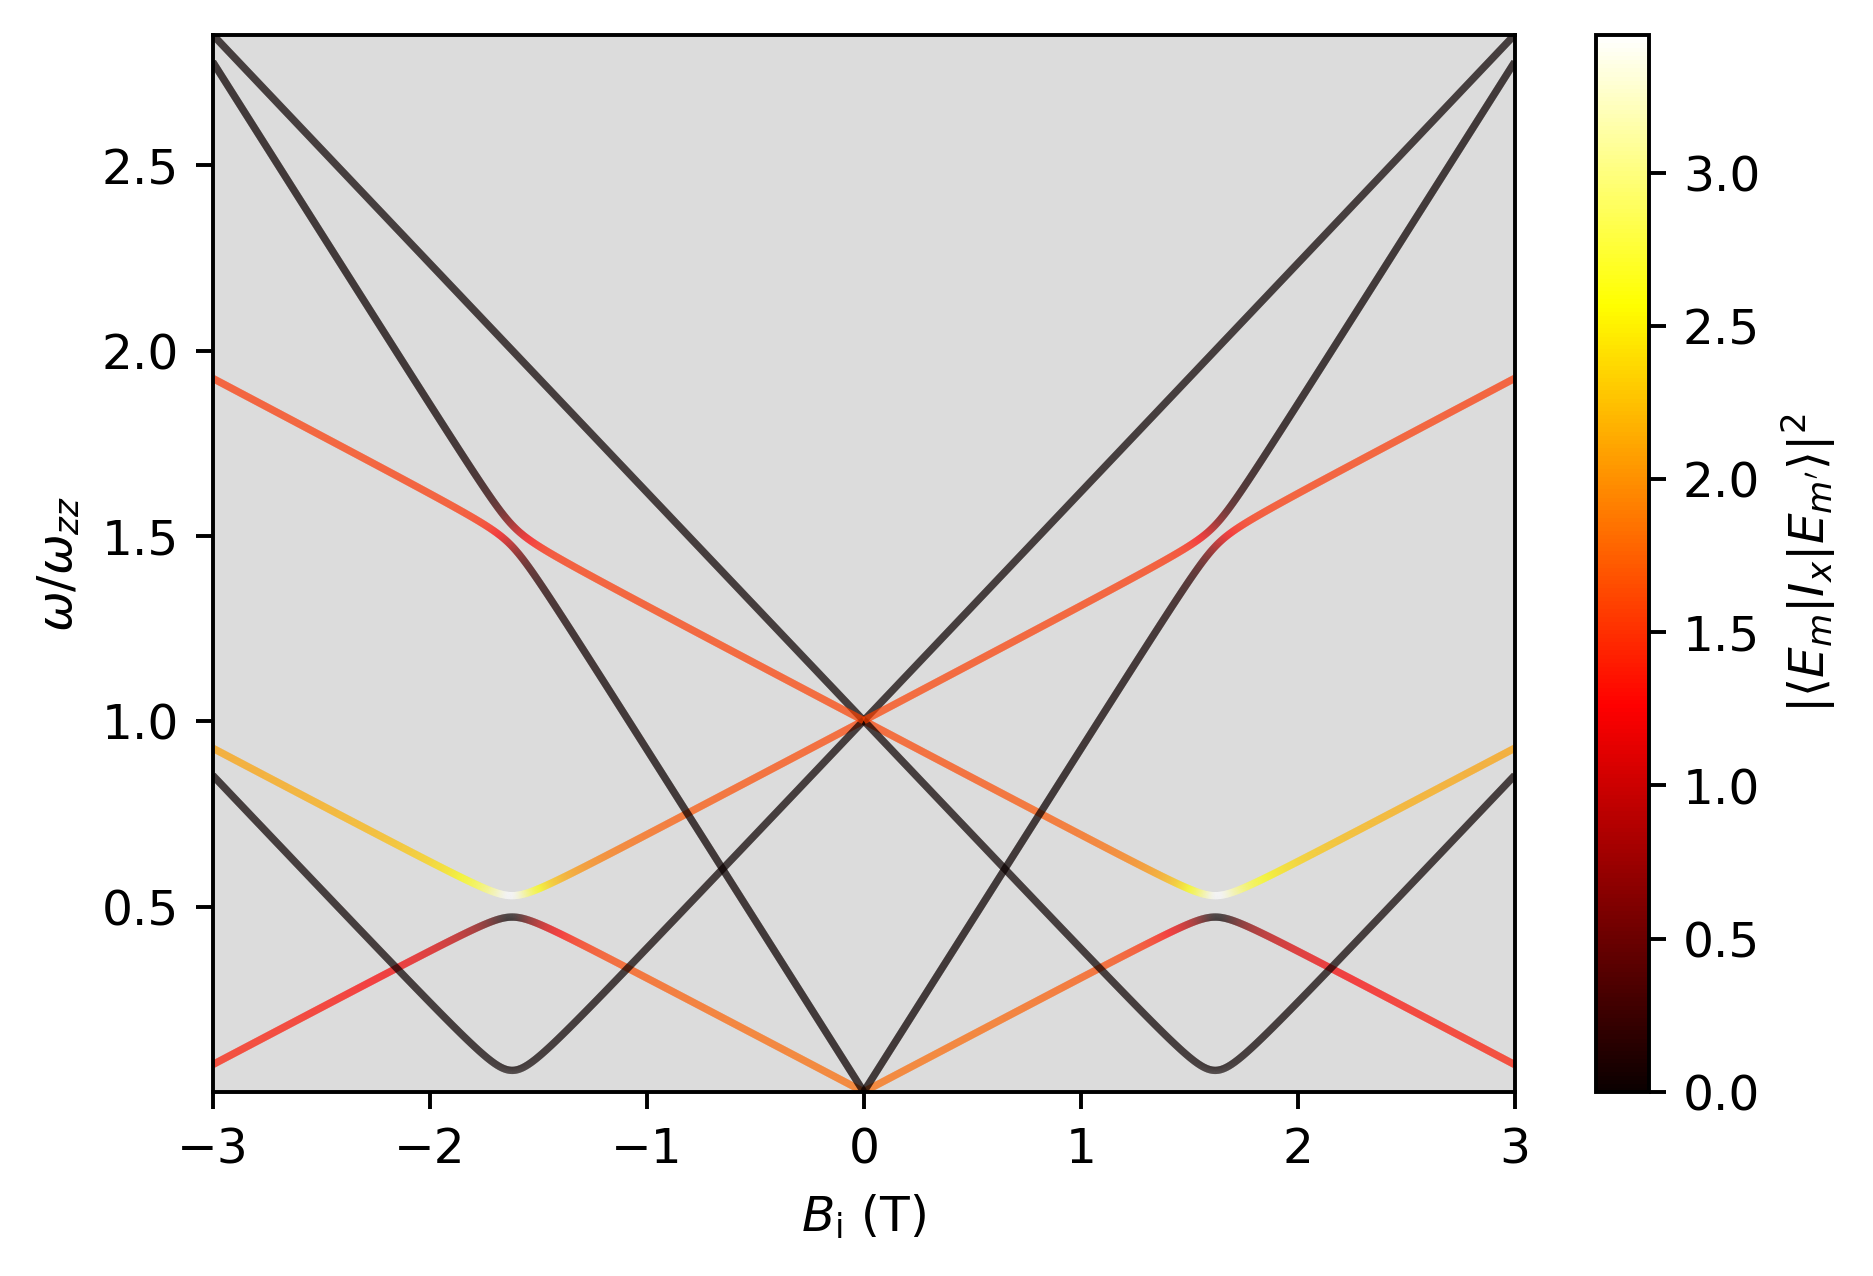

In [11]:
def make_plot(x, y_data, c_data, ax):
    ymax, ymin = find_max_min(y_data)
    cmax, cmin = find_max_min(c_data)
    for i in range(len(y_data)):
        y = y_data[i]
        c = c_data[i]            
        
        # This creates the points as a N x 1 x 2 array so that we can stack points
        # together easily to get the segments. The segments array for line collection
        # needs to be (numlines) x (points per line) x 2 (for x and y)
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Create a continuous norm to map from data points to colors
        norm = plt.Normalize(cmin, cmax)
        lc = LineCollection(segments, cmap='hot', norm=norm)
        
        # Set the values used for colormapping
        lc.set_array(c)
        #lc.set_linewidth(2)
        line = ax.add_collection(lc)
        
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(ymin, ymax)

    return line


def transition_rate(spin, i1, i2, V, w, I):
    n = int(2*spin + 1)
    N = V.shape[0]
    n = V.shape[1]
    rate = np.zeros(N, dtype=complex)
    trans_freq = w[:, i2] - w[:, i1]
    for m in range(n):
        for mp in range(n):
            if m != mp:
                w_diff = w[:, m] - w[:, mp]
                delta = (np.abs(trans_freq) == np.abs(w_diff)).astype(int)
                if not np.all(delta == 0):
                    ket = np.reshape(V[:, :, mp], (N, n, 1))
                    bra = np.conj(np.reshape(V[:, :, m], (N, 1, n)))
                    Iket = I@ket
                    braIket = bra@Iket
                    rate += np.squeeze(np.conj(braIket)*braIket)
                    
    if np.all(np.imag(rate) == 0):
        return np.real(rate)
    else:
        raise ValueError("Something isn't real!!!")

N = 5000 # Number of data points
I = 3/2
n = int(2*I + 1)
Ix, Iy, Iz, Ip, Im = quant.get_spin_matrices(I)
gamma = 7.292*mega # Gyromagnetic ratio, per Nick's document
B0 = [0, 0, 0]
Bi = [0, 0, np.linspace(-3, 3, N)]
efg = np.array([[-0.45, 0, 0],
                [0, -0.55, 0],
                [0, 0, 1]])*1e21
Q = nmr.get_Q('As', 75).n
Hq = get_Hq(I, Q, efg)
Hz = get_Hz(I, gamma, B0, Bi)
omega_zz = e*Q*np.abs(efg[2][2])/2/hbar
H = Hz + Hq
_E, _V = np.linalg.eig(H)
E, V = eig_sort(np.real(_E), _V)
w = E/hbar

freqs = []
rates = []
I_mat = Ix
for i in range(n):
    for j in range(n):
        f = w[:, i] - w[:, j]
        r = transition_rate(I, i, j, V, w, I_mat)
        if not np.all(f == 0) and np.all(f >= 0.):
            freqs.append(tuple(f))
            rates.append(tuple(r))
freqs = np.array(freqs)
rates = np.array(rates)

fig, axs = plt.subplots(nrows=1, ncols=1, sharey=True, dpi=350, gridspec_kw={'wspace': 0})
axs = [axs]
for _ in Bi:
    if type(_) != int:
        x = _
        
line = make_plot(x, freqs/omega_zz, rates, axs[0])
axs[0].set_xlabel('$B_\mathrm{i}$ (T)')
axs[0].set_ylabel('$\omega/\omega_{zz}$')
colorbar_label_dict = {str(Ix): 'I_x', str(Iy): 'I_y', str(Ip): 'I_+'}
colorbar_label = colorbar_label_dict[str(I_mat)]
fig.colorbar(line, label=r"$\left|\left\langle E_{m}\right|" + colorbar_label + r"\left| E_{m'} \right\rangle\right|^2$")
axs[0].set_facecolor("gainsboro")

# Magnetic Moment

/Users/jaafar/anaconda3/envs/pnic/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in true_divide
/Users/jaafar/anaconda3/envs/pnic/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide


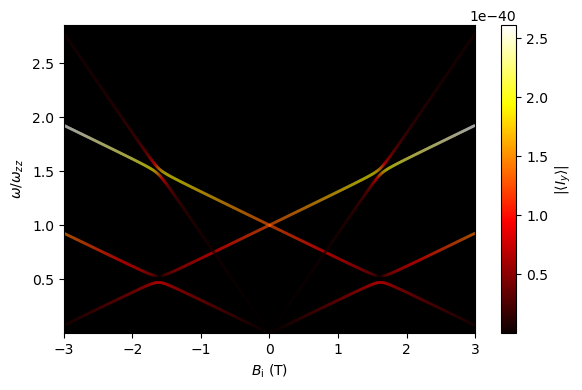

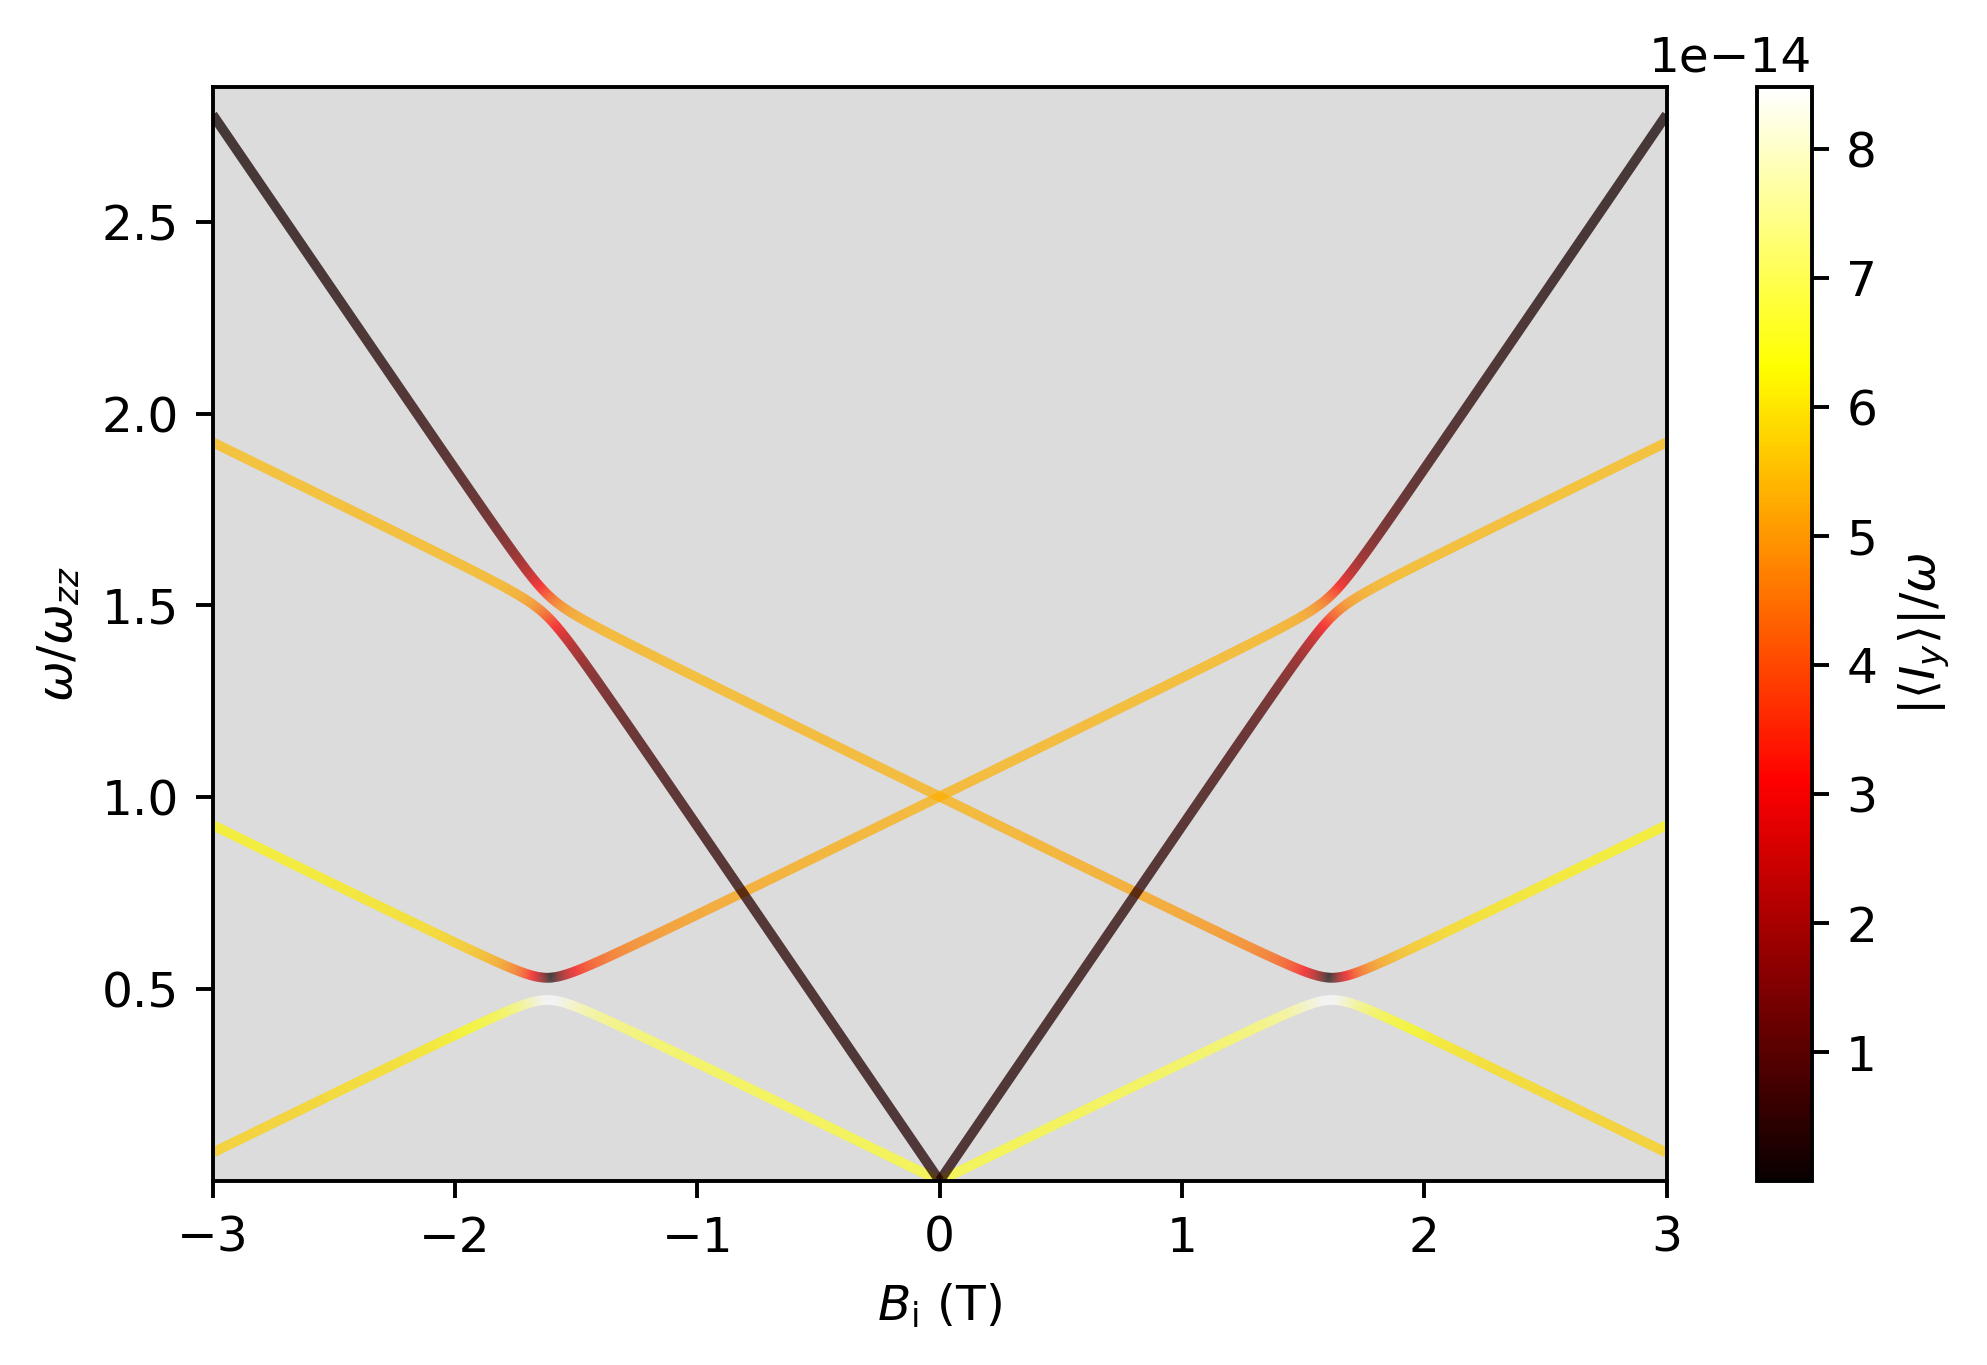

In [12]:
def make_plot(x, y_data, c_data, ax):
    ymax, ymin = find_max_min(y_data)
    cmax, cmin = find_max_min(c_data)
    for i in range(y_data.shape[0]):
        y = y_data[i]
        c = c_data[i]

        if not np.any(np.isnan(c)):                 
            # This creates the points as a N x 1 x 2 array so that we can stack points
            # together easily to get the segments. The segments array for line collection
            # needs to be (numlines) x (points per line) x 2 (for x and y)
            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            # Create a continuous norm to map from data points to colors
            norm = mpl.colors.Normalize(cmin, cmax)
            lc = LineCollection(segments, cmap='hot', norm=norm)

            # Label
            #ax.annotate(fr'$\omega_{i}$', (1.01, y[-1]), xycoords=('axes fraction', 'data'), size='small', color='r')
            #ax.annotate(fr'$\omega_{i}$', (0.05, y[0]), xycoords=('axes fraction', 'data'), size='small', ha='right', color='r')

            # Set the values used for colormapping
            lc.set_array(c)
            lc.set_linewidth(2)
            line = ax.add_collection(lc)
        
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(ymin, ymax)

    return line

def get_beta(p, q, i):
    n = p.shape[-1]
    if len(p.shape) < 2:
        N = 1
    else:
        N = p.shape[0]
    I = (n - 1)/2
    Ix, Iy, Iz, _, _ = quant.get_spin_matrices(I)
    I_mat = {'x': Ix, 'y': Iy, 'z': Iz}
    ket = np.reshape(q, (N, n, 1))
    bra = np.conj(np.reshape(p, (N, 1, n)))
    Iket = I_mat[i]@ket
    braIket = np.squeeze(bra@Iket)
    
    return braIket

def sigma_cross(vec):
    sigma_x, sigma_y, sigma_z, _, _ = (2*_ for _ in quant.get_spin_matrices(1/2))
    vec = [np.array(_) for _ in vec]
    N = vec[0].shape[-1]
    a = np.array(vec).reshape((3, N, 1, 1))
    i = a[1, ...]*sigma_z - a[2, ...]*sigma_y
    j = a[0, ...]*sigma_z - a[2, ...]*sigma_x
    k = a[0, ...]*sigma_y - a[1, ...]*sigma_x
    
    return np.array([i, -j, k])

def get_I_avg(p, q, args):
    n = int(2*args.I + 1)
    c = np.zeros(3)
    c[0] = np.matmul(args.rf, [1, 0, 0])
    c[1] = np.matmul(args.rf, [0, 1, 0])
    c[2] = np.matmul(args.rf, [0, 0, 1])
    
    E_pq = args.E[..., q] - args.E[..., p]
    w_pq = E_pq/hbar
    _x_term = np.zeros(args.N)
    _y_term = np.zeros(args.N)
    for j, d in enumerate(['x', 'y', 'z']):
        _beta = get_beta(args.V[..., p], args.V[..., q], d)
        _x_term += c[j]*np.real(_beta)
        _y_term += c[j]*np.imag(_beta)
    a_over_theta = np.sqrt(_x_term**2 + _y_term**2)
    theta = args.a/a_over_theta
    nhat = np.array([_x_term, _y_term, np.zeros(args.N)])/a_over_theta.reshape((1, args.N))
    nhat_x_sig = sigma_cross(nhat)
    const = hbar*E_pq/(2*(2*args.I + 1)*k*args.T)
    
    I = {}
    for i, axis in enumerate(['x', 'y', 'z']):
        beta_pq = get_beta(args.V[..., p], args.V[..., q], axis)
        magmom_vec = np.squeeze(np.array([0, 1])@(nhat_x_sig[2, ...]*np.sin(2*args.a))@np.array([[1], [0]]))
        magmom_1 = const*magmom_vec*beta_pq*np.exp(1j*w_pq*args.t)
        I[axis] = np.abs(np.real(magmom_1 + np.conj(magmom_1)))
    
    return I

I_avg_args = Namespace()
N = 5000
I_avg_args.I = 3/2
I_avg_args.T = 30
I_avg_args.t = 0
I_avg_args.rf = [1, 0, 0]
I_avg_args.a = np.pi/4
B0 = [0, 0, 0]
Bi = [0, 0, np.linspace(-3, 3, N)]
# efg = np.array([[-0.45, 0, 0],
#                 [0, -0.55, 0],
#                 [0, 0, 1]])*1e21
# efg = np.array([[-0.45, 0, 0],
#                 [0, -0.44444448, 0],
#                 [0, 0, 0.9]])*1e21
Q = nmr.get_Q('As', 75).n
#w_zz = e*Q*np.abs(efg[2][2])/2/hbar
#Hq = get_Hq(I, Q, efg)
gamma = 7.292*mega # Gyromagnetic ratio, per Nick's document
eta = 0.1
Vzz = 1e21
wzz = e*Q*Vzz/2/hbar
Hq = (3*e*Vzz*Q/(4*I*(2*I - 1)*h))*nmr.get_norm_H(I, eta)
Hz = get_Hz(I, gamma, B0, Bi)
H = Hz + Hq
_E, _V = np.linalg.eig(H)
E, V = eig_sort(np.real(_E), _V)
I_avg_args.E = E
I_avg_args.V = V
I_avg_args.N = N

n = int(2*I_avg_args.I + 1)
num_combs = int(scipy.special.comb(n, 2))
freqs = []
I_avgs = {'x':[], 'y':[], 'z':[]}
pq = []
#df = pd.DataFrame(columns = ['freq', 'Ix', 'Iy', 'Iz', 'pq'])
cols = []
for col_name in ['freq', 'Ix', 'Iy', 'Iz', 'pq']:
    cols += [col_name + str(i+1) for i in range(num_combs)]
df = pd.DataFrame(columns = cols)
for p in range(n):
    for q in range(n):
        w = (E[..., q] - E[..., p])/hbar
        I_avg = get_I_avg(p, q, I_avg_args)
        if np.all(w > 0):
            freqs.append(w)
            I_avgs['x'].append(I_avg['x'])
            I_avgs['y'].append(I_avg['y'])
            I_avgs['z'].append(I_avg['z'])
            pq.append([str(p) + str(q)])
freqs = np.array(freqs)
I_avgs['x'] = np.array(I_avgs['x'])
I_avgs['y'] = np.array(I_avgs['y'])
I_avgs['z'] = np.array(I_avgs['z'])
pq = np.array(pq)
# for i in range(num_combs):
#     df['freq' + str(i+1)] = pd.Series(freqs[i, :])
#     df['Ix' + str(i+1)] = pd.Series(I_avgs['x'][i, :])
#     df['Iy' + str(i+1)] = pd.Series(I_avgs['y'][i, :])
#     df['Iz' + str(i+1)] = pd.Series(I_avgs['z'][i, :])
#     df['pq' + str(i+1)] = pd.Series(pq[i, :])
# df['Bi'] = Bi[2]

# for i in range(num_combs):
#     sns.lineplot('Bi', f'freq{i+1}', data=df, hue=f'pq{i+1}')


plot_choice = 'y'
choice = 4
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, dpi=100)
#line = make_plot(Bi[2], freqs[choice].reshape((1, N))/w_zz, I_avgs[plot_choice][choice].reshape((1, N)), ax)
line = make_plot(Bi[2], freqs/wzz, I_avgs[plot_choice], ax)
#ax.plot(Bi[2], I_avgs[plot_choice][choice])
ax.set_xlabel(r'$B_\mathrm{i}$ (T)')
ax.set_ylabel(r'$\omega/\omega_{zz}$')
fig.colorbar(line, label=r"$\left|\langle I_" + plot_choice + r"\rangle\right|$")
ax.set_facecolor("black")
fig.tight_layout()
#fig.savefig('Iy_avg.png', bbox_inches='tight')

plot_choice = 'y'
choice = 4
fig1, ax1 = plt.subplots(nrows=1, ncols=1, sharey=True, dpi=350)
#line = make_plot(Bi[2], freqs[choice].reshape((1, N))/w_zz, I_avgs[plot_choice][choice].reshape((1, N)), ax)
line1 = make_plot(Bi[2], freqs/wzz, I_avgs[plot_choice]/(freqs*hbar), ax1)
#ax.plot(Bi[2], I_avgs[plot_choice][choice])
ax1.set_xlabel(r'$B_\mathrm{i}$ (T)')
ax1.set_ylabel(r'$\omega/\omega_{zz}$')
fig1.colorbar(line1, label=r"$\left|\langle I_" + plot_choice + r"\rangle\right|/\omega$")
ax1.set_facecolor("gainsboro")
fig1.tight_layout()
fig1.savefig('Iy_avg_norm.png', bbox_inches='tight')
Ix, Iy, Iz, _, _ = quant.get_spin_matrices(I)
# with np.printoptions(precision=5):
#     val, vec = np.linalg.eig(Iz)#np.sqrt(Ix@Ix + Iy@Iy + Iz@Iz))
#     print(val)
#     print(vec)

# Surface Plot

<IPython.core.display.Javascript object>


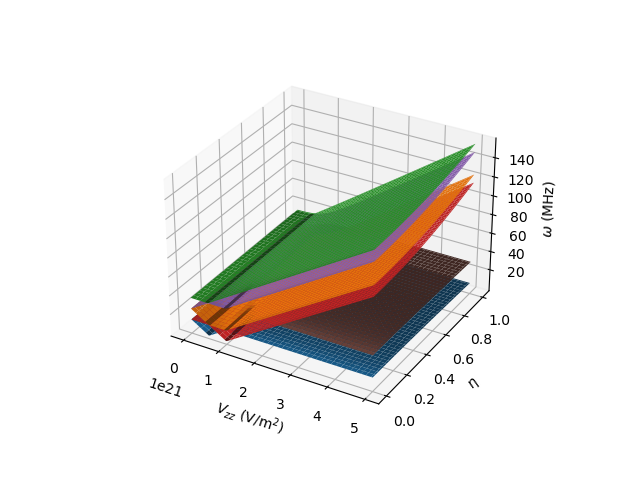

<IPython.core.display.Javascript object>


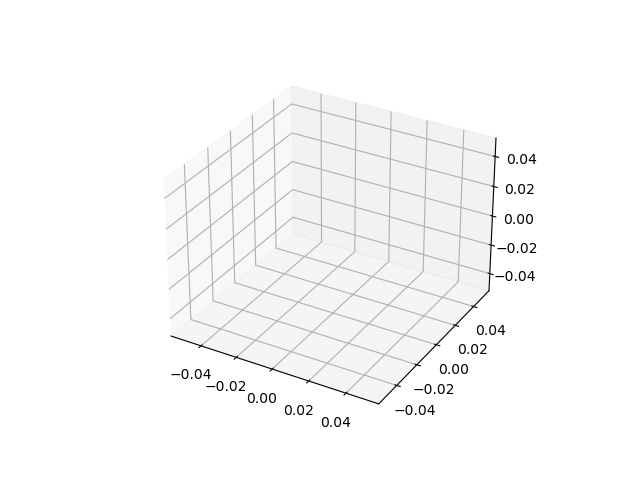

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]] [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]] [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/Users/jaafar/anaconda3/envs/pnic/lib/python3.7/site-packages/ipykernel_launcher.py:192: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/Users/jaafar/anaconda3/envs/pnic/lib/python3.7/site-packages/ipykernel_launcher.py:193: UserWarning: Z contains NaN values. This may result in rendering artifacts.


<IPython.core.display.Javascript object>


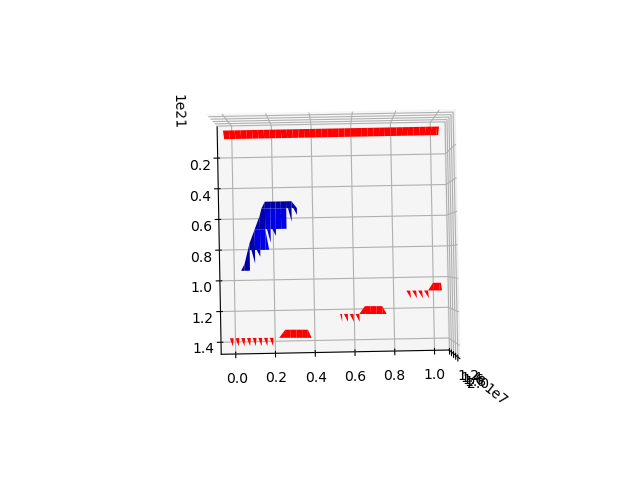

[[           nan            nan 8.92857143e+19 ...            nan
             nan            nan]
 [           nan            nan 8.92857143e+19 ...            nan
             nan            nan]
 [           nan            nan 8.92857143e+19 ...            nan
             nan            nan]
 ...
 [           nan            nan 8.92857143e+19 ...            nan
             nan            nan]
 [           nan            nan 8.92857143e+19 ...            nan
             nan            nan]
 [           nan            nan 8.92857143e+19 ...            nan
             nan            nan]] [[       nan        nan 0.         ...        nan        nan        nan]
 [       nan        nan 0.00892857 ...        nan        nan        nan]
 [       nan        nan 0.01785714 ...        nan        nan        nan]
 ...
 [       nan        nan 0.98214286 ...        nan        nan        nan]
 [       nan        nan 0.99107143 ...        nan        nan        nan]
 [       nan        nan 1.    

<IPython.core.display.Javascript object>


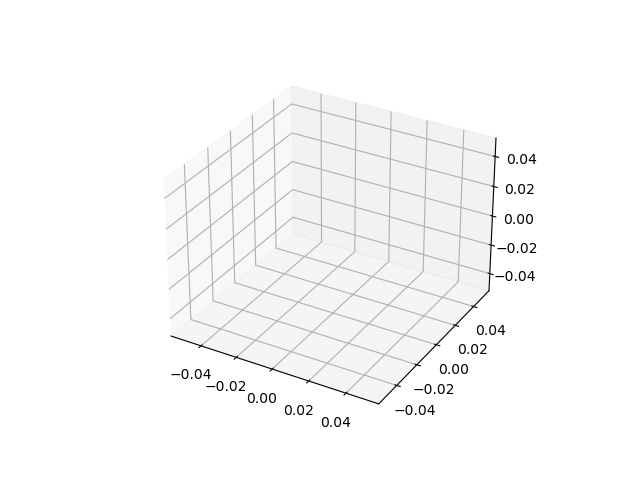

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]] [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]] [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


<IPython.core.display.Javascript object>


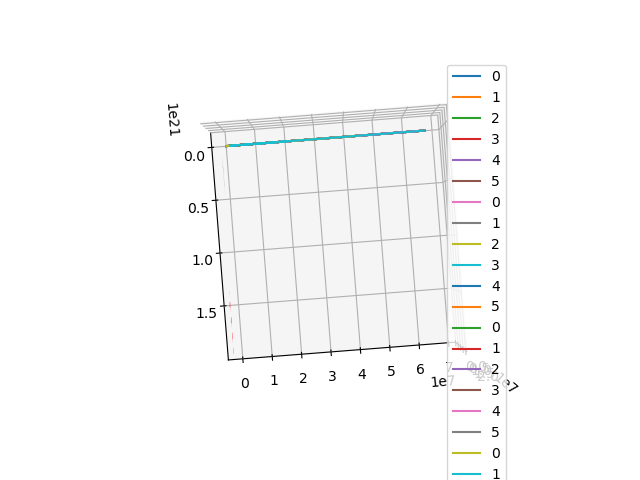

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]] [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]] [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


<IPython.core.display.Javascript object>


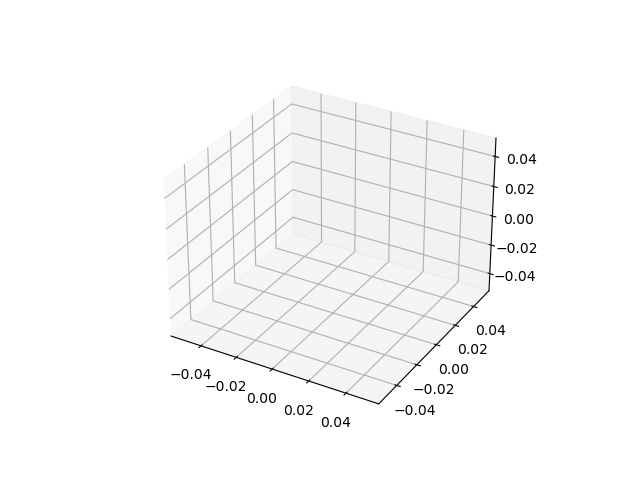

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]] [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]] [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


<IPython.core.display.Javascript object>


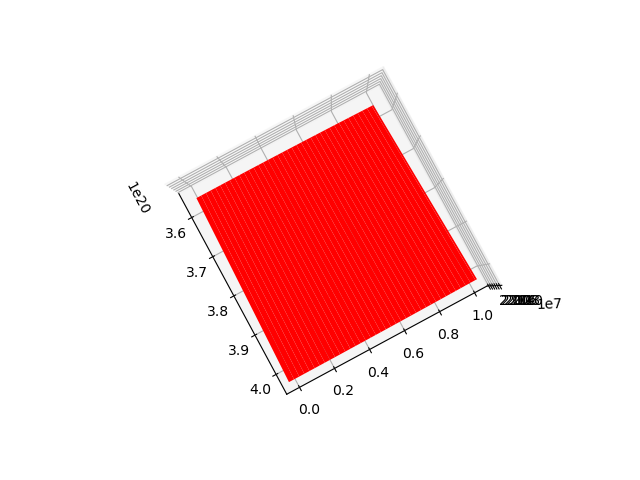

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]] [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]] [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [104]:
def make_plot(x, y_data, c_data, ax):
    ymax, ymin = find_max_min(y_data)
    cmax, cmin = find_max_min(c_data)
    for i in range(y_data.shape[0]):
        y = y_data[i]
        c = c_data[i]

        if not np.any(np.isnan(c)):                 
            # This creates the points as a N x 1 x 2 array so that we can stack points
            # together easily to get the segments. The segments array for line collection
            # needs to be (numlines) x (points per line) x 2 (for x and y)
            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            # Create a continuous norm to map from data points to colors
            norm = mpl.colors.Normalize(cmin, cmax)
            lc = LineCollection(segments, cmap='hot', norm=norm)

            # Label
            #ax.annotate(fr'$\omega_{i}$', (1.01, y[-1]), xycoords=('axes fraction', 'data'), size='small', color='r')
            #ax.annotate(fr'$\omega_{i}$', (0.05, y[0]), xycoords=('axes fraction', 'data'), size='small', ha='right', color='r')

            # Set the values used for colormapping
            lc.set_array(c)
            lc.set_linewidth(2)
            line = ax.add_collection(lc)
        
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(ymin, ymax)

    return line

def get_beta(p, q, i):
    n = p.shape[-1]
    if len(p.shape) < 2:
        N = 1
    else:
        N = p.shape[0]
    I = (n - 1)/2
    Ix, Iy, Iz, _, _ = quant.get_spin_matrices(I)
    I_mat = {'x': Ix, 'y': Iy, 'z': Iz}
    ket = np.reshape(q, (N, n, 1))
    bra = np.conj(np.reshape(p, (N, 1, n)))
    Iket = I_mat[i]@ket
    braIket = np.squeeze(bra@Iket)
    
    return braIket

def sigma_cross(vec):
    sigma_x, sigma_y, sigma_z, _, _ = (2*_ for _ in quant.get_spin_matrices(1/2))
    vec = [np.array(_) for _ in vec]
    N = vec[0].shape[-1]
    a = np.array(vec).reshape((3, N, 1, 1))
    i = a[1, ...]*sigma_z - a[2, ...]*sigma_y
    j = a[0, ...]*sigma_z - a[2, ...]*sigma_x
    k = a[0, ...]*sigma_y - a[1, ...]*sigma_x
    
    return np.array([i, -j, k])

def get_I_avg(p, q, args):
    n = int(2*args.I + 1)
    c = np.zeros(3)
    c[0] = np.matmul(args.rf, [1, 0, 0])
    c[1] = np.matmul(args.rf, [0, 1, 0])
    c[2] = np.matmul(args.rf, [0, 0, 1])
    
    E_pq = args.E[..., q] - args.E[..., p]
    w_pq = E_pq/hbar
    _x_term = np.zeros(args.N)
    _y_term = np.zeros(args.N)
    for j, d in enumerate(['x', 'y', 'z']):
        _beta = get_beta(args.V[..., p], args.V[..., q], d)
        _x_term += c[j]*np.real(_beta)
        _y_term += c[j]*np.imag(_beta)
    a_over_theta = np.sqrt(_x_term**2 + _y_term**2)
    theta = args.a/a_over_theta
    nhat = np.array([_x_term, _y_term, np.zeros(args.N)])/a_over_theta.reshape((1, args.N))
    nhat_x_sig = sigma_cross(nhat)
    const = hbar*E_pq/(2*(2*args.I + 1)*k*args.T)
    
    I = {}
    for i, axis in enumerate(['x', 'y', 'z']):
        beta_pq = get_beta(args.V[..., p], args.V[..., q], axis)
        magmom_vec = np.squeeze(np.array([0, 1])@(nhat_x_sig[2, ...]*np.sin(2*args.a))@np.array([[1], [0]]))
        magmom_1 = const*magmom_vec*beta_pq*np.exp(1j*w_pq*args.t)
        I[axis] = np.abs(np.real(magmom_1 + np.conj(magmom_1)))
    
    return I

I_avg_args = Namespace()
N = 113
I_avg_args.I = 3/2
I_avg_args.T = 30
I_avg_args.t = 0
I_avg_args.rf = [1, 0, 0]
I_avg_args.a = np.pi/4
n = int(2*I_avg_args.I + 1)
B0 = [0, 0, 0]
Bi = [0, 0, 1.6]
Q = nmr.get_Q('As', 75).n
gamma = 7.292*mega # Gyromagnetic ratio, per Nick's document
_eta = np.linspace(0, 1, N)
_vzz = np.linspace(0, 5, N)*1e21
Vzz, Eta = np.meshgrid(_vzz, _eta)
E = np.zeros((N, N, n))

for i in range(N):#, vzz in enumerate(_vzz):
    for j in range(N):#, eta in enumerate(_eta):
        vzz = Vzz[i, j]
        eta = Eta[i, j]
        Hq = (3*e*vzz*Q/(4*I*(2*I - 1)*h))*nmr.get_norm_H(I, eta)
        Hz = get_Hz(I, gamma, B0, Bi)
        H = Hz + Hq
        _E, _V = np.linalg.eig(H)
#         E, V = eig_sort(np.real(_E), _V)
#         I_avg_args.E = E
#         I_avg_args.V = V
#         I_avg_args.N = N
        E[i, j, ...] = np.sort(np.real(_E))

num_combs = int(scipy.special.comb(n, 2))
freqs = []
# I_avgs = {'x':[], 'y':[], 'z':[]}
pq = []
for p in range(n):
    for q in range(n):
        w = (E[..., q] - E[..., p])/hbar
#         I_avg = get_I_avg(p, q, I_avg_args)
        if np.all(w > 0):
            freqs.append(w)
#             I_avgs['x'].append(I_avg['x'])
#             I_avgs['y'].append(I_avg['y'])
#             I_avgs['z'].append(I_avg['z'])
            pq.append([str(p) + str(q)])
freqs = np.array(freqs)
# I_avgs['x'] = np.array(I_avgs['x'])
# I_avgs['y'] = np.array(I_avgs['y'])
# I_avgs['z'] = np.array(I_avgs['z'])
pq = np.array(pq)

%matplotlib notebook
fig1 = plt.figure(dpi=100)
ax1 = fig1.gca(projection='3d')
for i in range(freqs.shape[0]):
    ax1.plot_surface(Vzz, Eta, freqs[i]/mega)
ax1.set_xlabel(r'$V_{zz}$ (V/m$^2$)')
ax1.set_ylabel(r'$\eta$')
ax1.set_zlabel(r'$\omega$ (MHz)')
    
# plot_choice = 'y'
# choice = 4
# fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, dpi=100)
# #line = make_plot(Bi[2], freqs[choice].reshape((1, N))/w_zz, I_avgs[plot_choice][choice].reshape((1, N)), ax)
# line = make_plot(Bi[2], freqs/wzz, I_avgs[plot_choice], ax)
# #ax.plot(Bi[2], I_avgs[plot_choice][choice])
# ax.set_xlabel(r'$B_\mathrm{i}$ (T)')
# ax.set_ylabel(r'$\omega/\omega_{zz}$')
# fig.colorbar(line, label=r"$\left|\langle I_" + plot_choice + r"\rangle\right|$")
# ax.set_facecolor("black")
# fig.tight_layout()
# #fig.savefig('Iy_avg.png', bbox_inches='tight')

# plot_choice = 'y'
# choice = 4
# fig1, ax1 = plt.subplots(nrows=1, ncols=1, sharey=True, dpi=350)
# #line = make_plot(Bi[2], freqs[choice].reshape((1, N))/w_zz, I_avgs[plot_choice][choice].reshape((1, N)), ax)
# line1 = make_plot(Bi[2], freqs/wzz, I_avgs[plot_choice]/(freqs*hbar), ax1)
# #ax.plot(Bi[2], I_avgs[plot_choice][choice])
# ax1.set_xlabel(r'$B_\mathrm{i}$ (T)')
# ax1.set_ylabel(r'$\omega/\omega_{zz}$')
# fig1.colorbar(line1, label=r"$\left|\langle I_" + plot_choice + r"\rangle\right|/\omega$")
# ax1.set_facecolor("gainsboro")
# fig1.tight_layout()
# fig1.savefig('Iy_avg_norm.png', bbox_inches='tight')
# Ix, Iy, Iz, _, _ = quant.get_spin_matrices(I)
# # with np.printoptions(precision=5):
# #     val, vec = np.linalg.eig(Iz)#np.sqrt(Ix@Ix + Iy@Iy + Iz@Iz))
# #     print(val)
# #     print(vec)
ind1 = np.unravel_index(find_nearest(freqs/mega, 11.8), freqs.shape)
ind2 = np.unravel_index(find_nearest(freqs/mega, 20.6), freqs.shape)
freqs[ind1], Vzz[ind1[1:]], Eta[ind1[1:]], freqs[ind2], Vzz[ind2[1:]], Eta[ind2[1:]]
for i in range(6):
    fig2 = plt.figure(dpi=100)
    ax2 = fig2.gca(projection='3d')
    _z1 = np.where(np.abs(freqs[i]/mega - 11.8) < 0.1, freqs[i], np.nan)
    _z2 = np.where(np.abs(freqs[i]/mega - 20.6) < 1, freqs[i], np.nan)
    _x1 = np.where(np.abs(freqs[i]/mega - 11.8) < 0.1, Vzz, np.nan)
    _x2 = np.where(np.abs(freqs[i]/mega - 20.6) < 1, Vzz, np.nan)
    _y1 = np.where(np.abs(freqs[i]/mega - 11.8) < 0.1, Eta, np.nan)
    _y2 = np.where(np.abs(freqs[i]/mega - 20.6) < 1, Eta, np.nan)
    ax2.plot_surface(_x1, _y1, _z1, color='b')
    ax2.plot_surface(_x2, _y2, _z2, color='r')
    print(_x2, _y2, _z2)


In [32]:
freqs[ind1], Vzz[ind1[1:]], Eta[ind1[1:]], freqs[ind2], Vzz[ind2[1:]], Eta[ind2[1:]]

(11800141.119438173,
 8.937875751503006e+22,
 0.002004008016032064,
 20600509.778746814,
 6.6733466933867735e+22,
 0.01603206412825651)

In [14]:
i1 = 1
i2 = 5
freq_ratio = freqs[i1]/freqs[i2]#np.nanmin(freqs, axis=0)/np.nanmax(freqs, axis=0)
ratio_idx = find_nearest(freq_ratio, 0.55)
p1, q1 = tuple(int(_) for _ in pq[i1][0])
p2, q2 = tuple(int(_) for _ in pq[i2][0])
with np.printoptions(precision=3):
    print(f'eta = {eta}')
    print(f'B_internal = {np.abs(Bi[2][ratio_idx])}')
    print(f'w{i1}/w{i2} = {freq_ratio[ratio_idx]}')
    print(f'w{i1} (transition from p to q):')
    print(f'\t|p> = {V[ratio_idx, :, p1]}')
    print(f'\t|q> = {V[ratio_idx, :, q1]}')
    print(f'w{i2} (transition from p to q):')
    print(f'\t|p> = {V[ratio_idx, :, p2]}')
    print(f'\t|q> = {V[ratio_idx, :, q2]}')

eta = 1.0


TypeError: 'float' object is not subscriptable

In [ ]:
I_avg_args = Namespace()
N = 100
I_avg_args.I = 3/2
I_avg_args.T = 30
I_avg_args.t = 0
I_avg_args.rf = [1, 0, 0]
I_avg_args.a = np.pi/4
B0 = [0, 0, 0]
Bi = [0, 0, 1.6]
Q = nmr.get_Q('As', 75).n
eta = np.linspace(0, 1, N)
Vzz = 10e21
wzz = e*Q*Vzz/2/hbar
Hq = (3*e*Vzz*Q/(4*I*(2*I - 1)*h))*nmr.get_norm_H(I, eta)
Hz = get_Hz(I, gamma, B0, Bi)
H = Hz + Hq
_E, _V = np.linalg.eig(H)
E, V = eig_sort(np.real(_E), _V)
I_avg_args.E = E
I_avg_args.V = V
I_avg_args.N = N

n = int(2*I_avg_args.I + 1)
num_combs = int(scipy.special.comb(n, 2))
freqs = []
I_avgs = {'x':[], 'y':[], 'z':[]}
pq = []
for p in range(n):
    for q in range(n):
        w = (E[..., q] - E[..., p])/hbar
        I_avg = get_I_avg(p, q, I_avg_args)
        if np.all(w > 0):
            freqs.append(w)
            I_avgs['x'].append(I_avg['x'])
            I_avgs['y'].append(I_avg['y'])
            I_avgs['z'].append(I_avg['z'])
            pq.append([str(p) + str(q)])
freqs = np.array(freqs)
I_avgs['x'] = np.array(I_avgs['x'])
I_avgs['y'] = np.array(I_avgs['y'])
I_avgs['z'] = np.array(I_avgs['z'])
pq = np.array(pq)

plot_choice = 'y'
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, dpi=100)
line = make_plot(eta, freqs/wzz, I_avgs[plot_choice], ax)
ax.set_xlabel(r'$\eta$')
ax.set_ylabel(r'$\omega/\omega_{zz}$')
fig.colorbar(line, label=r"$\left|\langle I_" + plot_choice + r"\rangle\right|$")
ax.set_facecolor("gainsboro")
fig.tight_layout()
fig.savefig('Iy_avg_eta.png', bbox_inches='tight')

plot_choice = 'y'
fig1, ax1 = plt.subplots(nrows=1, ncols=1, sharey=True, dpi=350)
line1 = make_plot(eta, freqs, I_avgs[plot_choice]/(freqs*hbar), ax1)
ax1.set_xlabel(r'$\eta$')
ax1.set_ylabel(r'$\omega/\omega_{zz}$')
fig1.colorbar(line1, label=r"$\left|\langle I_" + plot_choice + r"\rangle\right|/\omega$")
ax1.set_facecolor("gainsboro")
fig1.tight_layout()
fig1.savefig('Iy_avg_eta_norm.png', bbox_inches='tight')
i1 = 0
i2 = 1
Bint_idx = find_nearest(Bi[2], 1.6)
freq_ratio = freqs[i1]/freqs[i2]
ratio_idx = find_nearest(freq_ratio, 0.55)
freq_ratio[ratio_idx], eta[ratio_idx]
p1, q1 = tuple(int(_) for _ in pq[i1][0])
p2, q2 = tuple(int(_) for _ in pq[i2][0])
with np.printoptions(precision=3):
    print(f'eta = {eta[ratio_idx]}')
    print(f'B_internal = {Bi[2]}')
    print(f'w{i1}/w{i2} = {freq_ratio[ratio_idx]}')
    print(f'w{i1} (transition from p to q):')
    print(f'\t|p> = {V[ratio_idx, :, p1]}')
    print(f'\t|q> = {V[ratio_idx, :, q1]}')
    print(f'w{i2} (transition from p to q):')
    print(f'\t|p> = {V[ratio_idx, :, p2]}')
    print(f'\t|q> = {V[ratio_idx, :, q2]}')